<a href="https://colab.research.google.com/github/JaejunHaa/AIB_Project/blob/main/AI_03_%ED%95%98%EC%9E%AC%EC%A4%80_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%capture
# import sys

# if 'google.colab' in sys.modules:
#     # Install packages in Colab
#     !pip install category_encoders==2.*
#     !pip install eli5
#     !pip install pandas-profiling==2.*
#     !pip install pdpbox
#     !pip install shap
#     !pip install plotly==4.*
#     !pip install --upgrade scikit-learn
#     from google.colab import drive
#     drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 0. 데이터

*   캐글에서 선택한 휴대폰 부품의 성능(스펙)에 따른 가격에 대한 데이터
*   과제에서 진행했던 분류 문제가 아닌 회귀 문제 중 가장 관심있는 도메인에서 데이터를 선택
*   다양한 스펙 중 어느 스펙이 가장 가격에 큰 영향을 끼치는 지 확인해보기 위함
*   일반적으로 제조사에서는 AP의 성능(코어, 클럭속도), RAM 용량, 카메라의 성능을 위주로 제품군을 나누기 때문에 해당 특성들이 가격에 가장 큰 영향을 미칠 것이라 분석 전 가정




# 1. 데이터 확인

In [ ]:
# 데이터 불러오기 - 휴대폰 스펙과 가격 데이터 from kaggle
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/df_section2.csv')

df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


## 1-1. Feature 설명

*   battery_power: Total energy a battery can store in one time measured in mAh
*   blue: Has bluetooth or not
*   clock_speed: speed at which microprocessor executes instructions
*   dual_sim: Has dual sim support or not
*   fc: Front Camera mega pixels
*   four_g: Has 4G or not
*   int_memory: Internal Memory in Gigabytes
*   m_dep: Mobile Depth in cm
*   mobile_wt: Weight of mobile phone
*   n_cores: Number of cores of processor
*   pc: Primary Camera mega pixels
*   px_height: Pixel Resolution Height
*   px_width: Pixel Resolution Width
*   ram: Random Access Memory in Megabytes
*   sc_h: Screen Height of mobile in cm
*   sc_w: Screen Width of mobile in cm
*   talk_time: longest time that a single battery charge will last when you are
*   three_g: Has 3G or not
*   touch_screen: Has touch screen or not
*   wifi: Has wifi or **not**
*   price_range: This is the target variable with value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).



> *   휴대폰의 다양한 부품의 성능(스펙)을 통해 가격을 예측하기 위해서는 회귀(Regression) 문제로 접근
*   그러나 타겟(price_range) 데이터가 이미 0~3까지로 분류되어 있어 다중분류(Multi-Class Classification) 문제로 진행
*   회귀 문제라고 생각하고 해당 데이터를 선택했으나, 다중분류는 다루어보지 않았기 때문에 변경하지 않고 선택

##1-2. Profile 분석

In [ ]:
# Pandas profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# 중복값 확인
df.duplicated().sum()

0

*   결측치 없음
*   모두 범주/수치형 데이터로 문자형 데이터 없음
*   타겟 데이터는 가격이나, 0~3까지로 가격대별로 분류되어 있으며, 독특하게 25%씩 완벽하게 균형을 이루어 분포하고 있음




## 1-3. Baseline & Evaluation Metrics

In [ ]:
# 타겟의 비율 확인
target = 'price_range'

df[target].value_counts(normalize=True)

3    0.25
2    0.25
1    0.25
0    0.25
Name: price_range, dtype: float64

*   분류 문제에서 타겟의 베이스라인은 최빈값의 범주이고, 해당 데이터에서는 타겟 데이터의 분포가 모두 일정함
*   따라서 해당 데이터의 베이스라인은 0.25이고, 균형잡힌(balanced) 데이터이므로 평가지표는 accuracy를 이용

## 1-4. 데이터 나누기

In [ ]:
# 훈련 / 테스트 데이터로 나누기(train_test_split 사용, train/test = 80/20, random_state=2)
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size = 0.8, random_state=2)

# 훈련데이터를 훈련 / 검증데이터로 나누기(train_test_split 사용, train/validation = 80/20, random_state=2)
train, val = train_test_split(train, train_size = 0.8, random_state=2)

train.shape, val.shape, test.shape

((1280, 21), (320, 21), (400, 21))

# 2. EDA 및 전처리

## 2-1. 상관계수 확인

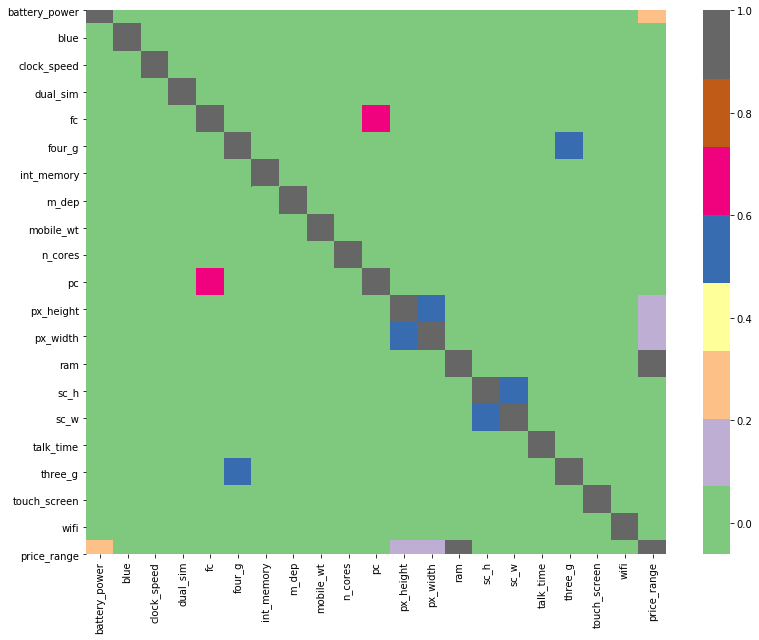

price_range      1.000000
ram              0.915648
battery_power    0.220899
px_height        0.167319
px_width         0.164922
pc               0.052191
sc_w             0.047170
int_memory       0.045180
fc               0.042904
three_g          0.041233
sc_h             0.037026
blue             0.027736
n_cores          0.024905
dual_sim         0.019381
four_g           0.009193
clock_speed     -0.004197
talk_time       -0.004867
wifi            -0.006668
m_dep           -0.013637
touch_screen    -0.019579
mobile_wt       -0.052639
Name: price_range, dtype: float64

In [ ]:
plt.figure(figsize=(13,10))
sns.heatmap(train.corr(), cmap='Accent')
plt.show()

train.corr().sort_values(by=["price_range"],ascending=False).iloc[0].sort_values(ascending=False)


> *   타겟의 경우 RAM 용량과 높은 상관관계를 보이고, battery_power, px_width/height와도 양의 상관관계를 가짐
*   예상과 달리 AP 관련 특징인 clock_speed, n_cores와는 큰 상관관계를 가지지 않음
*   예상대로 Pixel, Screen의 height/width는 서로 상관관계를 가짐
*   따라서 특성공학을 통해 해당 특성들은 가공
*   카메라 관련 특성(pc, fc)과 네트워크 지원 관련 특징(three_g, four_g)도 비교적 높은 상관관계를 가짐을 확인
*   카메라 관련 특성의 경우 가격대에 따라 전/후면을 비슷하게 구성하여 그럴 것 같으나 가격과의 높은 상관관계는 보이지 않음
*   네트워크 관련해서는 3G 통신을 지원하지 않고 4G 통신만 지원하는 경우는 거의 없을 것이기 때문에 상관관계를 가질 것으로 예상







## 2-2. 데이터 랭글링

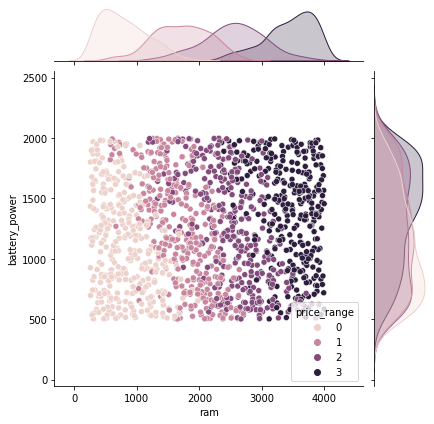

In [ ]:
# 타겟과 상관계수가 높은 ram, battery_power 특성의 분포 시각화
sns.jointplot(data=train, x='ram', y='battery_power', hue='price_range');



> *   가격에 따라 RAM 용량과 battry 용량이 높은 상관관계를 가지고 있음을 확인
*   두 특성은 직접적인 연관관계가 있는 것은 아니나, 가격대에 따라 급을 나누기 위해 부품을 다르게 넣었기 때문에 위와 같은 분포를 가지게 되었을 것





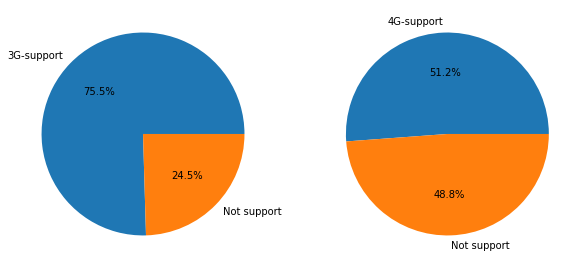

In [ ]:
# 3G, 4G 통신 특성 비율 시각화
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,25))

labels_3g = ['3G-support','Not support']
labels_4g = ['4G-support','Not support']

ax1.pie(train['three_g'].value_counts().values, labels=labels_3g, autopct='%.1f%%')

ax2.pie(train['four_g'].value_counts().values, labels=labels_4g, autopct='%.1f%%')

plt.show()

In [ ]:
# 3G 통신을 지원하는/하지 않는 기종에 따른 4G 통신 지원 여부 확인
threeg_fourg = train.groupby(['three_g', 'four_g']).count().iloc[:,0]
threeg_fourg

three_g  four_g
0        0         314
1        0         311
         1         655
Name: battery_power, dtype: int64



> *   예상대로 3G 통신을 지원하지 않으면서 4G 통신을 지원하는 기기는 존재하지 않음
*   3G 통신과 4G 통신을 모두 지원하지 않는 휴대폰도 꽤 존재하는 것으로 보아 2G, 3G, 4G 통신이 모두 공존하는 2010년대 초중반 데이터일 것으로 추정





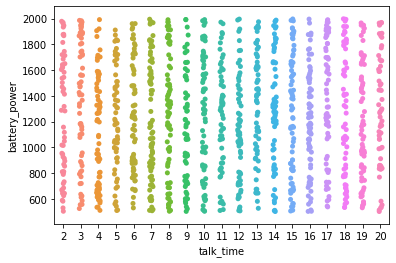

In [ ]:
# 배터리 용량과 사용 시간에 대한 시각화
sns.stripplot(data=train, x='talk_time', y='battery_power');



> *   배터리 용량과 휴대폰의 사용시간은 상관관계를 가질 것 같으나, 분포/상관계수를 보면 전혀 관계가 없음
*   이는 배터리 용량 뿐만 아니라 휴대폰의 크기와 AP의 성능과 같은 효율성이 영향을 끼치는 것으로 추정





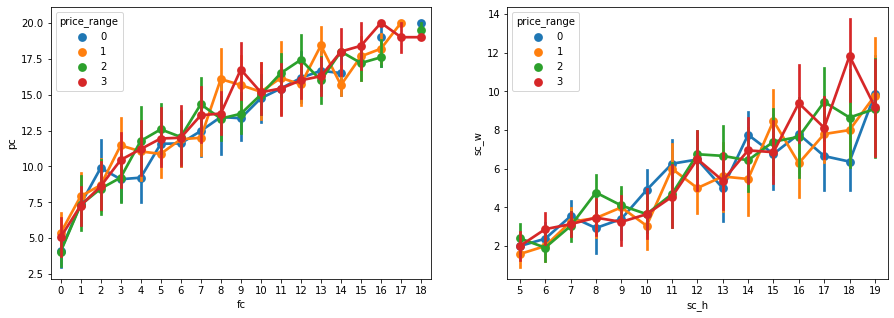

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.pointplot(data=train, x='fc', y='pc', hue='price_range', ax=ax[0])
sns.pointplot(data=train, x='sc_h', y='sc_w', hue='price_range', ax=ax[1])

plt.show()



> *   카메라 관련 특성(fc, pc), 스크린 크기 관련 특성(sc_h, sc_w) 모두 서로 높은 양의 상관관계를 보임
*   타겟과 관련해서는 큰 관련이 없는 듯 보이나 비싼 가격대의 휴대폰의 경우에는 화면이 대체로 큰 편으로 보임





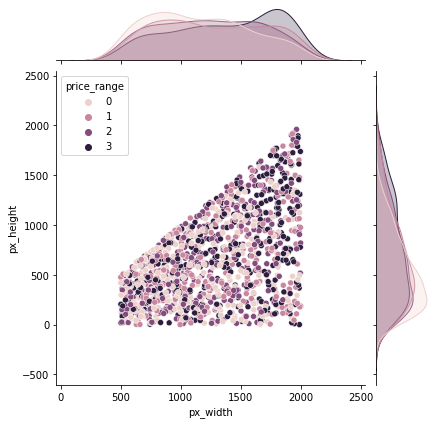

In [ ]:
sns.jointplot(data=train, x='px_width', y='px_height', hue='price_range');



> *   휴대폰의 비율로 인해 해상도의 width가 height보다 큰 경우는 존재하지 않음
*   그러나 특정 상관관계를 가지지 않고 무작위로 분포하는 것으로 보임
*   스크린 크기와 비슷하게 비싼 가격대의 휴대폰은 대체로 해상도가 높은 경향을 보임


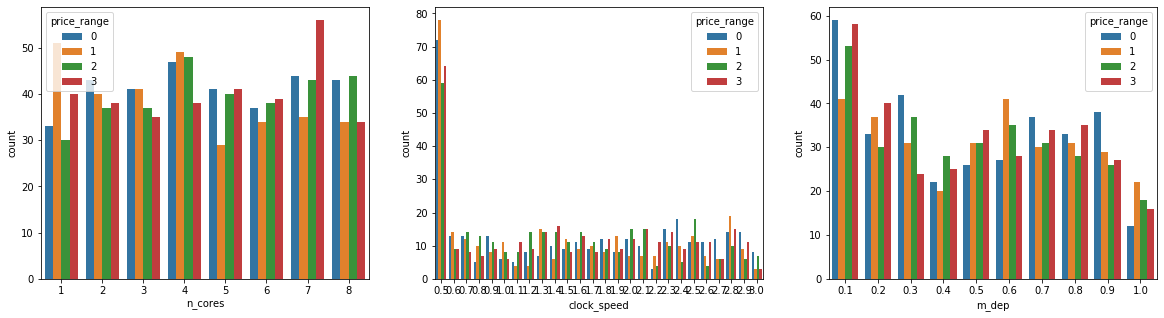

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.countplot(data=train, x='n_cores', hue='price_range', ax=ax[0])
sns.countplot(data=train, x='clock_speed', hue='price_range', ax=ax[1])
sns.countplot(data=train, x='m_dep', hue='price_range', ax=ax[2])

plt.show()


> *   AP관련 특성인 코어의 개수와 클럭 속도는 타겟과 거의 상관관계를 보이지 않음
*   카메라 관련 특성으로 추정되는 m_dep 특성도 낮을수록 성능이 좋은 것이나, 특별히 타겟과의 상관관계를 보이지 않음


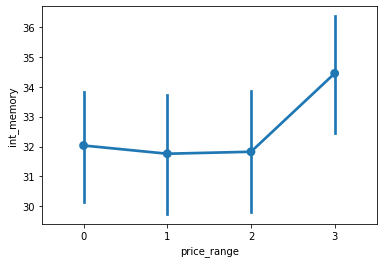

In [ ]:
sns.pointplot(data=train, x='price_range', y='int_memory')

## 2-3. 전처리 및 특성공학

In [ ]:
def engineer(df) :

    # 스크린 사이즈 특성(height, width)을 하나로 통합(inch)
    df['sc_inch'] = np.sqrt(df['sc_h']**2+df['sc_w']**2)

    # 스크린 사이즈와 해상도를 나누어 밀도 feature 생성(ppi)
    df['ppi'] = np.sqrt(df['px_height']**2+df['px_width']**2)/df['sc_inch']

    # 새로운 특성으로 대체한 특성 삭제
    col_dup = ['sc_h', 'sc_w', 'px_height', 'px_width']
    df = df.drop(col_dup, axis=1)

    # 다른 특성과 높은 상관관계를 가지는 특성 삭제
    col_cor = ['fc']
    df = df.drop(col_cor, axis=1)
    
    return df

train = engineer(train)
val = engineer(val)

train

,battery_power,blue,clock_speed,dual_sim,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,three_g,touch_screen,wifi,price_range,sc_inch,ppi
330,662,0,0.5,0,0,20,0.8,138,1,10,2125,15,0,1,1,1,22.671568,69.743513
1326,769,1,1.2,0,0,17,0.1,95,8,4,1877,11,0,0,1,1,18.110770,110.838985
666,890,1,2.2,1,0,44,0.5,198,8,13,751,3,0,0,0,0,7.615773,283.500441
1753,995,0,1.3,1,0,10,0.1,104,4,3,609,5,1,0,1,0,11.401754,167.214395
1885,713,0,0.9,1,0,42,0.1,94,1,14,928,9,0,0,1,0,15.620499,98.335179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,1698,0,2.8,0,1,7,0.8,131,8,12,2992,17,1,1,0,2,15.297059,33.252466
1478,1254,1,2.3,0,1,44,0.2,149,1,10,3011,12,1,1,0,2,8.062258,129.142557
789,1614,0,1.9,0,1,55,0.3,188,3,17,3914,13,1,0,0,3,21.400935,74.007258
1396,539,0,1.5,0,1,26,0.2,137,6,8,3948,15,1,1,1,3,21.095023,96.939805


# 3. 데이터 분석

In [ ]:
features_train = train.columns.drop([target])
features_val = val.columns.drop([target])

X_train = train[features_train]
y_train = train[target]
X_val = val[features_val]
y_val = val[target]

## 3-1. Logistic Regression

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

pipe_lr = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=2)
)

pipe_lr.fit(X_train, y_train);

y_train_pred = pipe_lr.predict(X_train)
y_val_pred = pipe_lr.predict(X_val)

print(f'Train set Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Validation set Accuracy: \n{classification_report(y_val, y_val_pred)}')

Train set Accuracy: 0.915625
Validation set Accuracy: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        73
           1       0.87      0.76      0.81        78
           2       0.82      0.87      0.84        89
           3       0.91      0.90      0.91        80

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.86       320



## 3-2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(n_jobs=-1, random_state=2)
)

pipe_rf.fit(X_train, y_train);

y_train_pred = pipe_rf.predict(X_train)
y_val_pred = pipe_rf.predict(X_val)

print(f'Train set Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Validation set Accuracy: \n{classification_report(y_val, y_val_pred)}')

Train set Accuracy: 1.0
Validation set Accuracy: 
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        73
           1       0.87      0.71      0.78        78
           2       0.74      0.75      0.75        89
           3       0.82      0.88      0.85        80

    accuracy                           0.82       320
   macro avg       0.83      0.83      0.83       320
weighted avg       0.83      0.82      0.82       320



## 3-3. XGBClassifier

In [ ]:
from xgboost import XGBClassifier

pipe_xg= make_pipeline(
    StandardScaler(), 
    XGBClassifier(n_jobs=-1, random_state=2)
)

pipe_xg.fit(X_train, y_train);

y_train_pred = pipe_xg.predict(X_train)
y_val_pred = pipe_xg.predict(X_val)

print(f'Train set Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Validation set Accuracy: \n{classification_report(y_val, y_val_pred)}')

Train set Accuracy: 0.9671875
Validation set Accuracy: 
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        73
           1       0.85      0.77      0.81        78
           2       0.80      0.79      0.80        89
           3       0.87      0.90      0.88        80

    accuracy                           0.85       320
   macro avg       0.85      0.85      0.85       320
weighted avg       0.85      0.85      0.85       320





> *   정확도를 기준으로 Logistic Regression의 성능이 가장 좋았음
*   베이스라인보다 나은 결과가 나왔으나 모든 모델에서 과적합이 일어남
*   따라서 과적합을 피하고, 모델을 최적화하기 위하여 hyperparameter tuning 진행




## 3-4. Hyperparameter Tuning

In [ ]:
# Logistic Regression
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipe_lr = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=2)
)

param_dict = {
    'logisticregression__C': [0.0001, 0.001, 0.01, 0.1],
}

random_grid_lr = RandomizedSearchCV(pipe_lr,
                                 param_distributions = param_dict,
                                 n_iter = 100,
                                 scoring = 'f1_macro',
                                 random_state = 2,
                                 cv = 5,
                                 verbose = 1,
                                 n_jobs = -1
                                 )

random_grid_lr.fit(X_train, y_train)

print(f'Best parameter of Logistic Regression: {random_grid_lr.best_params_}')

best_lr = random_grid_lr.best_estimator_

y_train_pred_lr = best_lr.predict(X_train)
y_val_pred_lr = best_lr.predict(X_val)

accuracy_train_lr = accuracy_score(y_train, y_train_pred_lr)
accuracy_val_lr = accuracy_score(y_val, y_val_pred_lr)

print(f'Train set Accuracy of Logistic Regression: {accuracy_train_lr}')
print(f'Validation set Accuracy of Logistic Regression: \n{classification_report(y_val, y_val_pred_lr)}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter of Logistic Regression: {'logisticregression__C': 0.1}
Train set Accuracy of Logistic Regression: 0.8921875
Validation set Accuracy of Logistic Regression: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        73
           1       0.85      0.77      0.81        78
           2       0.84      0.83      0.84        89
           3       0.90      0.94      0.92        80

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



In [ ]:
# Random Forest
pipe_rf = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(n_jobs=-1, random_state=2)
)

param_dict = {
    'randomforestclassifier__max_depth': randint(1, 5),
    'randomforestclassifier__n_estimators': [200, 500, 1000],
    'randomforestclassifier__max_features': uniform(0,1),
    'randomforestclassifier__min_samples_split': randint(1, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 10)

}
            
random_grid_rf = RandomizedSearchCV(pipe_rf,
                                 param_distributions = param_dict,
                                 n_iter = 100,
                                 scoring = 'f1_macro',
                                 random_state = 2,
                                 cv = 5,
                                 verbose = 1,
                                 n_jobs = -1
                                 )

random_grid_rf.fit(X_train, y_train)

print(f'Best parameter of Random Forest: {random_grid_rf.best_params_}')

best_rf = random_grid_rf.best_estimator_

y_train_pred_rf = best_rf.predict(X_train)
y_val_pred_rf = best_rf.predict(X_val)

accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
accuracy_val_rf = accuracy_score(y_val, y_val_pred_rf)

print(f'Train set Accuracy of Random Forest: {accuracy_train_rf}')
print(f'Validation set Accuracy of Random Forest: \n{classification_report(y_val, y_val_pred_rf)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameter of Random Forest: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 0.7455388102944811, 'randomforestclassifier__min_samples_leaf': 7, 'randomforestclassifier__min_samples_split': 9, 'randomforestclassifier__n_estimators': 1000}
Train set Accuracy of Random Forest: 0.84609375
Validation set Accuracy of Random Forest: 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        73
           1       0.80      0.71      0.75        78
           2       0.72      0.71      0.72        89
           3       0.79      0.85      0.82        80

    accuracy                           0.79       320
   macro avg       0.79      0.80      0.79       320
weighted avg       0.79      0.79      0.79       320



In [ ]:
# xgboost
pipe_xg= make_pipeline(
    StandardScaler(), 
    XGBClassifier(objective='multi:softmax', n_jobs=-1, random_state=2)
)

param_dict = {
    'xgbclassifier__max_depth': randint(1, 5),
    'xgbclassifier__min_child_weight': randint(20, 50),
    'xgbclassifier__gamma': uniform(0,1),
    'xgbclassifier__n_estimators': [200, 500, 1000],
    'xgbclassifier__learning rate': [0.01, 0.05, 0.1, 0.2]
}
            
random_grid_xg = RandomizedSearchCV(pipe_xg,
                                 param_distributions = param_dict,
                                 n_iter = 100,
                                 scoring = 'f1_macro',
                                 random_state = 2,
                                 cv = 5,
                                 verbose = 1,
                                 n_jobs = -1
                                 )

random_grid_xg.fit(X_train, y_train)

print(f'Best parameter of xgboost: {random_grid_xg.best_params_}')

best_xg = random_grid_xg.best_estimator_

y_train_pred_xg = best_xg.predict(X_train)
y_val_pred_xg = best_xg.predict(X_val)

accuracy_train_xg = accuracy_score(y_train, y_train_pred_xg)
accuracy_val_xg = accuracy_score(y_val, y_val_pred_xg)

print(f'Train set Accuracy of xgboost: {accuracy_train_xg}')
print(f'Validation set Accuracy of xgboost: \n{classification_report(y_val, y_val_pred_xg)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameter of xgboost: {'xgbclassifier__gamma': 0.2209981532931503, 'xgbclassifier__learning rate': 0.05, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 21, 'xgbclassifier__n_estimators': 1000}
Train set Accuracy of xgboost: 0.9796875
Validation set Accuracy of xgboost: 
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        73
           1       0.92      0.76      0.83        78
           2       0.82      0.84      0.83        89
           3       0.88      0.90      0.89        80

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



## 3-5. 성능비교

In [ ]:
score = pd.DataFrame([
    [accuracy_train_lr, accuracy_val_lr],
    [accuracy_train_rf, accuracy_val_rf],
    [accuracy_train_xg, accuracy_val_xg]],
    columns = ['Train Accuracy', 'Validation Accuracy'],
    index = ['Logistic Regression', 'Random Forest', 'XGBoost']
)

score.style.format("{:.3f}").highlight_max(['Train Accuracy', 'Validation Accuracy'], color='pink')

,Train Accuracy,Validation Accuracy
Logistic Regression,0.892,0.869
Random Forest,0.846,0.791
XGBoost,0.980,0.869




> *   hyper-parameter tuning 이후에도 Logistic Regression 모델의 예측 성능이 가장 좋음
*   다른 모델들은 과적합이 심하여 사용할 수 없는 모델
*   과적합을 피하기 위하여 데이터 사전 분리, pipeline 사용, hyper-parameter tuning을 시도해보았으나 실패

## 3-6. 최종 모델

In [ ]:
test = engineer(test)

features_test = test.columns.drop([target])
X_test = test[features_test]
y_test = test[target]

final_model = best_lr
y_pred = final_model.predict(X_test)

print(f'Test set Accuracy of xgboost: {accuracy_score(y_test, y_pred)}')

Test set Accuracy of xgboost: 0.87


# 4. ML 모델 해석

## 4-1. PDP

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


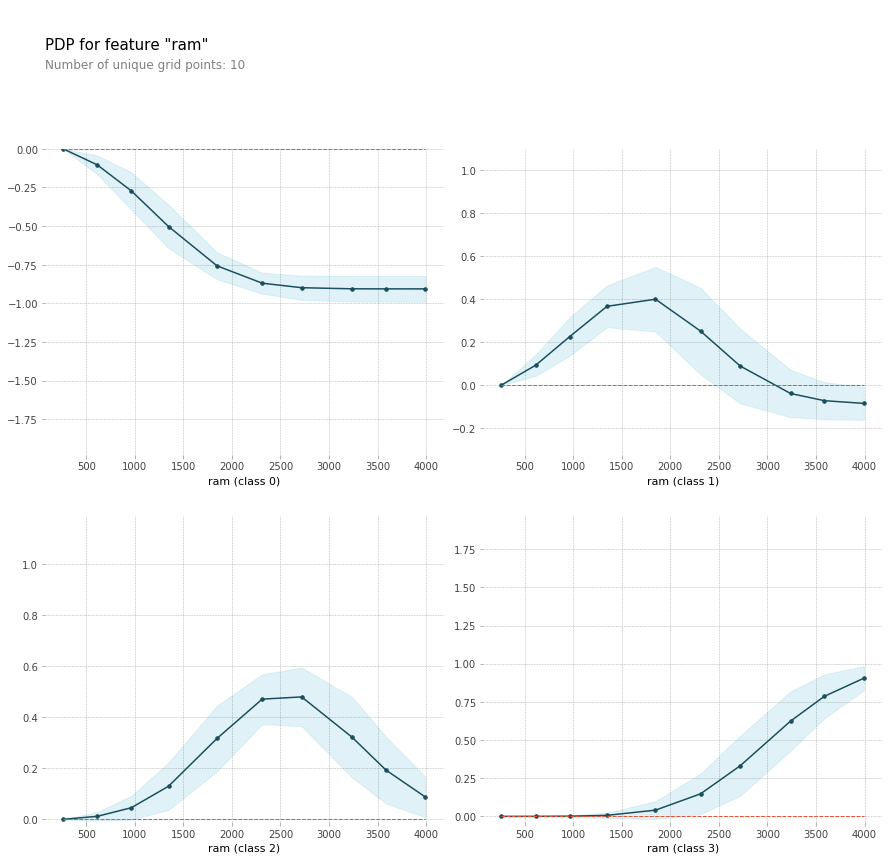

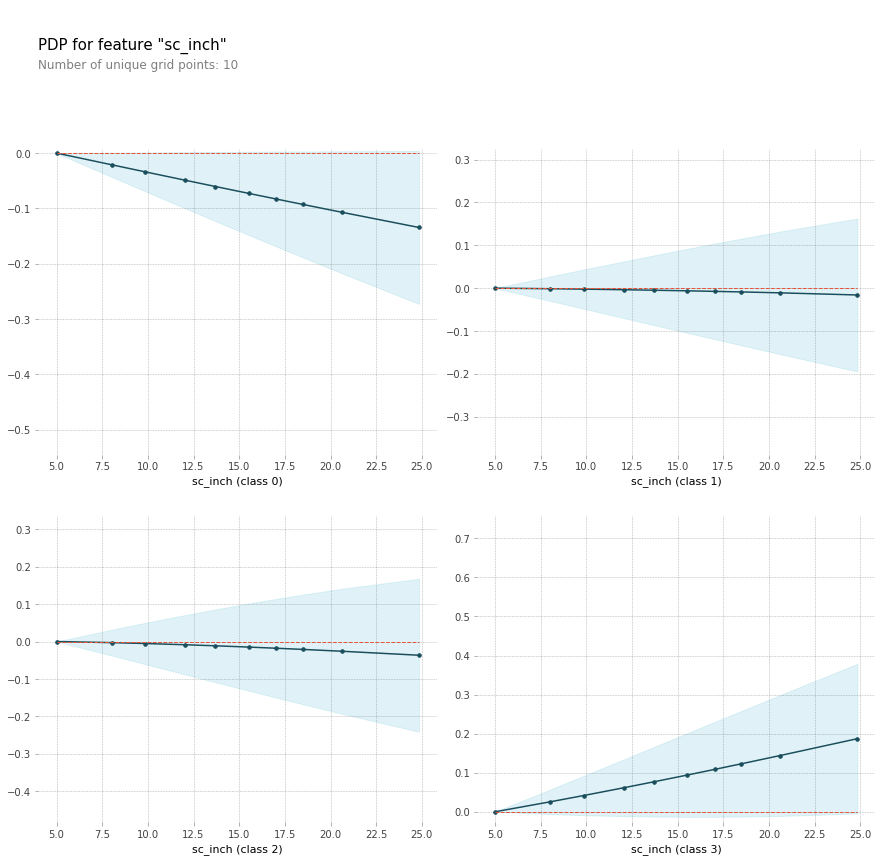

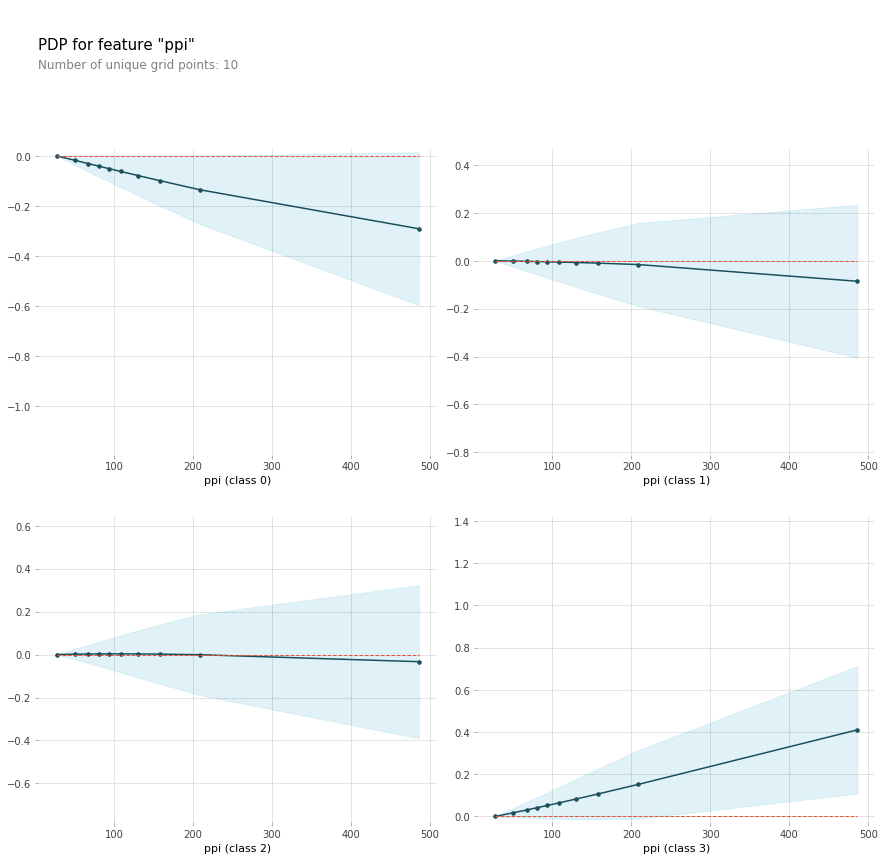

In [ ]:
# PDP plots
from pdpbox.pdp import pdp_isolate, pdp_plot

for i in ['ram', 'sc_inch', 'ppi']:
  feature = i
  isolated = pdp_isolate(
      model=final_model, 
      dataset=X_test, 
      model_features=X_test.columns, 
      feature=feature
  )
  pdp_plot(isolated, feature_name=feature);

## 4-2. SHAP

In [ ]:
# SHAP plots
import shap

model = LogisticRegression(random_state=2, C=0.1)

model.fit(X_train, y_train)

explainer = shap.LinearExplainer(model, X_train)
row = X_test.iloc[[0]]
shap_values = explainer.shap_values(row)


shap.initjs()
shap.force_plot(base_value = explainer.expected_value[0], 
                shap_values = shap_values[0], 
                features = row)


In [ ]:
row = X_test.iloc[[200]]
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(base_value = explainer.expected_value[0], 
                shap_values = shap_values[0], 
                features = row)

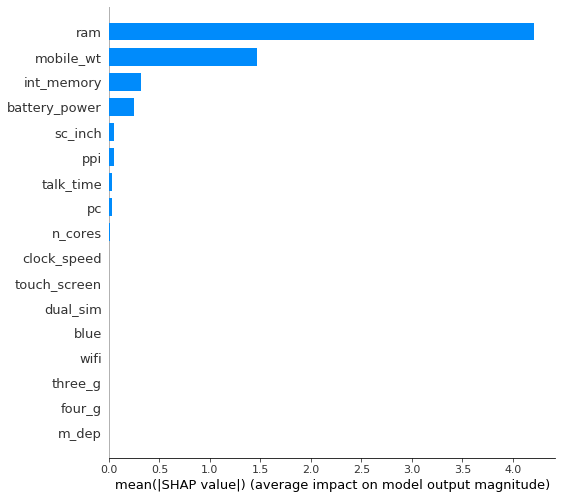

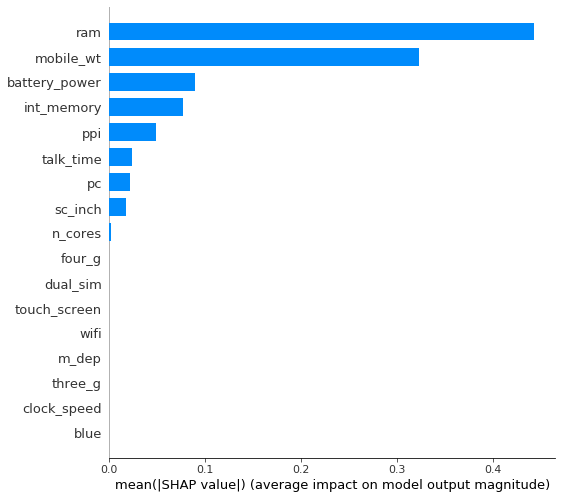

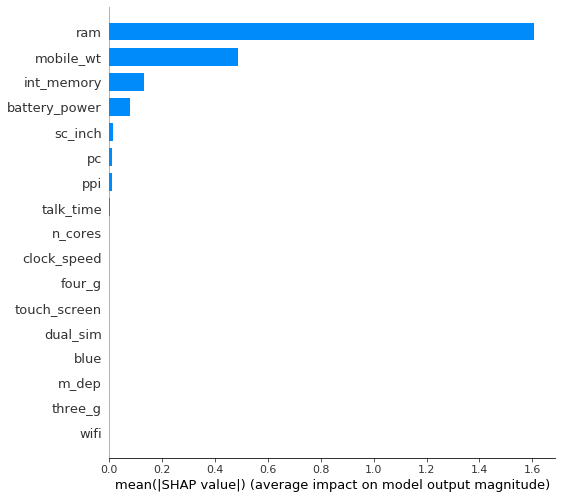

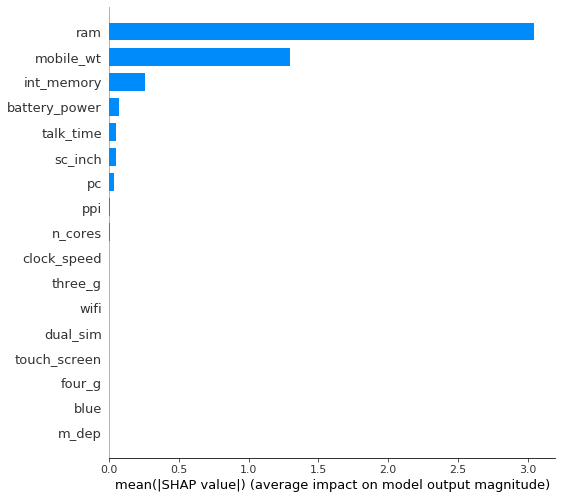

In [ ]:
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0], X_test, plot_type='bar')
shap.summary_plot(shap_values[1], X_test, plot_type='bar')
shap.summary_plot(shap_values[2], X_test, plot_type='bar')
shap.summary_plot(shap_values[3], X_test, plot_type='bar')

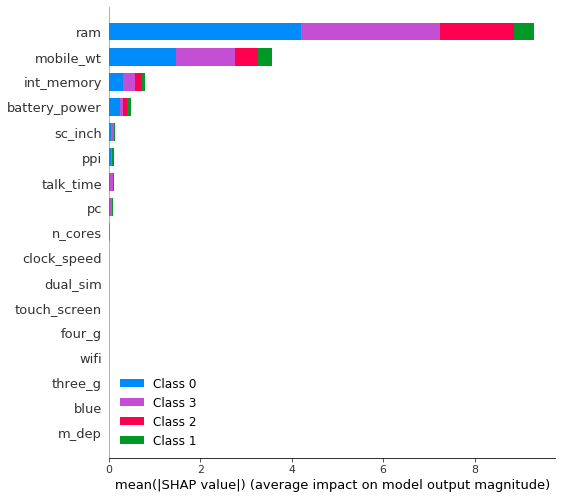

In [ ]:
shap.summary_plot(shap_values = shap_values,features = X_test)



> * RAM 용량이 휴대폰의 가격을 결정하는 가장 주요 특성
* 휴대폰의 무게와 스토리지 용량도 휴대폰의 가격을 결정하는데 주요한 영향을 끼침
* 새로 만든 두 특성인 스크린의 크기(sc_inch)와 해상도의 밀도(ppi)도 영향을 끼치나 영향력은 낮음
* 최초에 예상했던 AP와 카메라 관련 특성은 휴대폰 가격 책정에 큰 영향을 가지지못함
* 또한 가장 저렴한 휴대폰과 가장 비싼 휴대폰일수록 특성에 대한 영향을 많이 받는 것을 알 수 있는데, 이는 보통의 가격의 가지는 휴대폰에 비해 극단적으로 성능을 높이거나 낮추기 때문인 것으로 추정됨
